In [28]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import sklearn

# Бонусный трэк: градиентные спуски

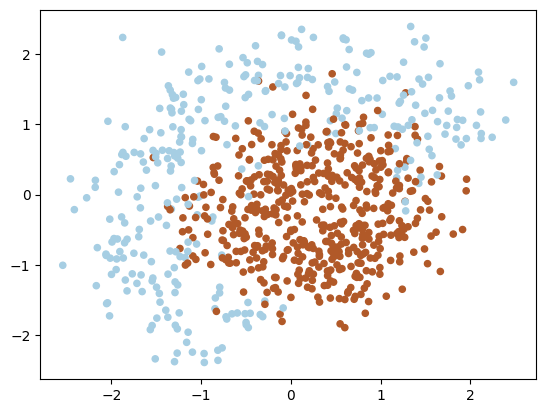

In [29]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, 
                               noise=0.2, factor=0.4, random_state=42)

ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [30]:
# добавим вектор из единичек
X = np.hstack((X, np.ones(X.shape[0])[:,np.newaxis]))
X

array([[ 1.20798057,  0.0844994 ,  1.        ],
       [ 0.76121787,  0.72510869,  1.        ],
       [ 0.55256189,  0.51937292,  1.        ],
       ...,
       [-1.22224754,  0.45743421,  1.        ],
       [ 0.43973452, -1.47275142,  1.        ],
       [ 1.4928118 ,  1.15683375,  1.        ]])

__[0.2 балла]__ реализуйте в `numpy` функцию для поиска вероятности того, что объект относится к первому классу


$$ \hat{y} = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$

Обратите внимание, что веса теперь идут на вход в эту функцию. 

In [31]:
# можно также взять функцию сигмоиду, сделать ее в нумпай и написать для перемножения массивов
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def probability(X, w):
    return sigmoid(np.dot(X,w))

In [32]:
X = np.array([[1,2], [3,4]])
y = np.array([1, 0])
w = np.array([0.5, 0.5])

assert np.allclose(probability(X, w), np.array([0.81757448, 0.97068777]))

__[0.2 балла]__ По аналогии реализуйте логистические потери. 

$$ L(w) =  - {1 \over n} \sum_{i=1}^n \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$

In [33]:
def compute_loss(X, y, w):
    result = -1/len(y) * np.sum((y * np.log(probability(X, w)) + (1-y) * np.log(1-probability(X, w))))
    return result

In [34]:
assert compute_loss(X, y, w) - 1.865581 < 1e-3

__[0.4 балла]__ Мы будем обучать модель методом градиентного спуска своими руками. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

In [35]:
def compute_grad(X, y, w):
    # Рассчитываем количество данных
    n = y.shape[0]
    # Вычисляем вероятности класса  для каждого примера
    t = np.dot(X, w)
    sigm = sigmoid(t)
    # Вычисляем градиент функции потерь кросс-энтропии
    grad = np.dot(X.T, (sigm - y)) / n
    return grad

In [36]:
assert np.allclose(compute_grad(X, y, w),np.array([1.36481889, 1.75895001]))

Функция ниже предназначена для визуализации процесса обучения. 

In [37]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,3))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

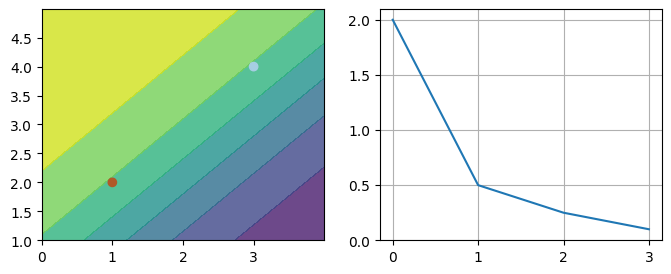

In [38]:
dummy_weights = np.linspace(-1, 1, 2)
visualize(X, y, dummy_weights, [2, 0.5, .25, .1])

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [0.4  балла] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



<Figure size 1200x500 with 0 Axes>

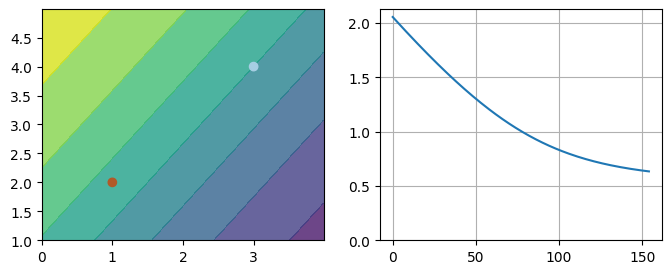

<Figure size 640x480 with 0 Axes>

In [39]:
np.random.seed(42)

w = np.array([0, 1.]) # веса

eta= 0.1 

epochs = 155
batch_size = 32
loss = np.zeros(epochs)
plt.figure(figsize=(12, 5))
history = []


for i in range(epochs):
    for j in range(0, X.shape[0], batch_size):
        x_batch = X[j: j + batch_size]
        #print(f'Иксы:{x_batch}')
        #print(f'Веса:{w}')
        y_batch = y[j: j + batch_size]
        gradient = compute_grad(x_batch, y_batch, w)
        w -= eta * gradient / batch_size
    loss = compute_loss(x_batch, y_batch, w)
    history.append(loss)
visualize(X, y, w, history)
plt.clf()

### [0.4 балла] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


<Figure size 1200x500 with 0 Axes>

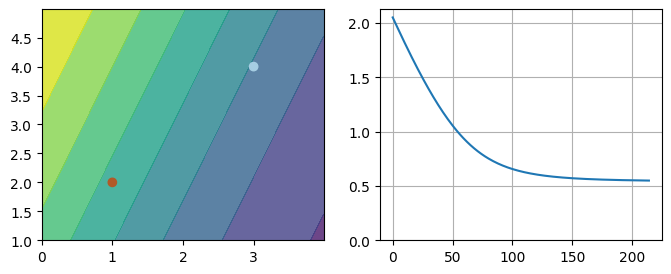

<Figure size 640x480 with 0 Axes>

In [40]:
np.random.seed(42)

w = np.array([0, 1.0])

eta = 0.05 
alpha = 0.2
nu = np.zeros_like(w)

history = []
epochs = 215
batch_size = 14
loss = np.zeros(epochs)
plt.figure(figsize=(12, 5))

for i in range(epochs):
    for j in range(0, X.shape[0], batch_size):
        x_batch = X[j: j + batch_size]
        y_batch = y[j: j + batch_size]
        gradient = compute_grad(x_batch, y_batch, w)
        nu = alpha * nu + eta * gradient / batch_size
        w -= nu
    loss = compute_loss(X, y, w)
    history.append(loss)

visualize(X, y, w, history)
plt.clf()


### [0.4 балла] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

<Figure size 1200x500 with 0 Axes>

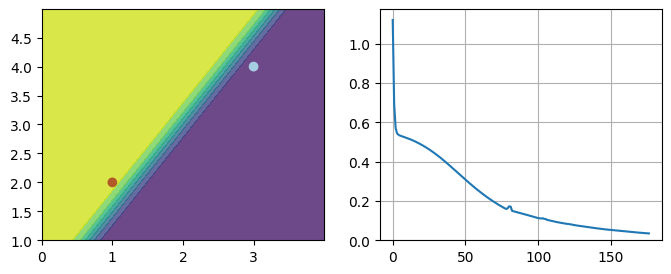

<Figure size 640x480 with 0 Axes>

In [41]:
np.random.seed(42)

w = np.array([0, 1.]) 

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

history = []
epochs = 177
batch_size = 16
loss = np.zeros(epochs)
plt.figure(figsize=(12,5))

for i in range(epochs):
    for j in range(0, X.shape[0], batch_size):
        X_batch = X[j: j + batch_size]
        y_batch = y[j: j + batch_size]
        gradient = compute_grad(x_batch, y_batch, w)
        g2 = alpha * g2 + (1 - alpha) * gradient ** 2
        w -=  eta / np.sqrt(g2 + eps) * gradient

    loss = compute_loss(X, y, w)
    history.append(loss)


visualize(X, y, w, history)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

**Траектории обучения различных вариаций градиентного спуска  различаются в зависимости от выбранного метода оптимизации и параметров обучения. Например, первые два варианта сходятся медленнее, чем метод, который использует более сложные шаги обновления, такой как  RMSProp.
Это ожидаемо, так как разные методы оптимизации имеют разные способы адаптации шага обновления к изменению градиента. Некоторые методы могут быть более эффективными для определенных задач, в то время как другие методы могут показать лучшие результаты для других задач.**


**Чтобы реализовать Adam, необходимо выполнить следующие шаги:**
- : 1 Инициализировать переменные. Например, скорость обновления и скользящее среднее квадратов градиента.
- : 2 Вычислить градиент функции потерь по всем параметрам модели.
- : 3 Обновить скользящее среднее квадратов градиента и скорость обновления.
- : 4 Вычислить скорректированные значения скользящих средних и скорости обновления.
- : 5 Обновить параметры модели с использованием скорректированных значений.
- : 6 Повторять шаги 2-5 для каждой эпохи обучения.

**Важно отметить, что параметры Adam могут зависеть от конкретной задачи и могут потребовать настройки для достижения лучших результатов.**